In [0]:

!pip install tqdm 
!pip install git+https://github.com/tensorflow/examples.git

In [292]:
from tensorflow.python.client import device_lib
str(device_lib.list_local_devices()[-1]).split('\n')[-2]

'physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"'

In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re 

import warnings
warnings.filterwarnings('ignore')

# Домашняя работа 
### Урок 6. Сегментация

Попробуйте обучить нейронную сеть U-Net на любом другом датасете. 
Опишите в комментарии к уроку - какой результата вы добились от нейросети? Что помогло вам улучшить ее точность?

In [294]:
from __future__ import absolute_import, division, print_function, unicode_literals

from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt


import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')

print(tf.__version__)

2.2.0-rc3


In [0]:
SEED = 1 
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
np.random.seed(SEED)
tf.compat.v1.set_random_seed(SEED)

### Dataset loading and preprocessing 

In [0]:
dataset, info = tfds.load('oxford_iiit_pet', with_info=True)

In [0]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [0]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [0]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [0]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
OUTPUT_CHANNELS = 3

In [0]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [0]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [0]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

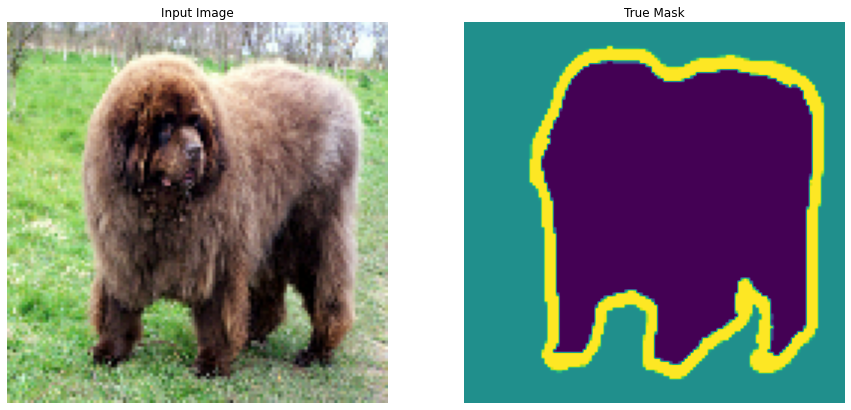

In [304]:
for image, mask in train.take(7):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [0]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

layer_names = [
    'block_1_expand_relu', 
    'block_3_expand_relu', 
    'block_6_expand_relu',  
    'block_13_expand_relu',
    'block_16_project', 
]
layers = [base_model.get_layer(name).output for name in layer_names]
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [0]:
up_stack = [
    pix2pix.upsample(512, 3), 
    pix2pix.upsample(256, 3), 
    pix2pix.upsample(128, 3),
    pix2pix.upsample(64, 3) 



]

In [0]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [0]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='rmsprop',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

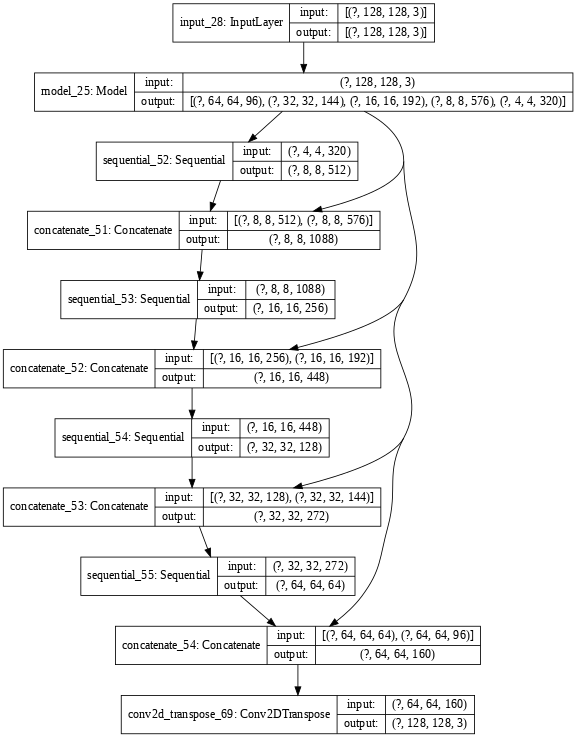

In [309]:
tf.keras.utils.plot_model(model, show_shapes=True,dpi= 60)

In [0]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [0]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

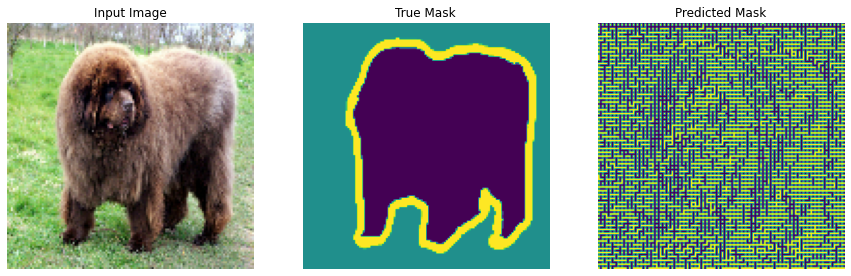

In [312]:
show_predictions()

In [0]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

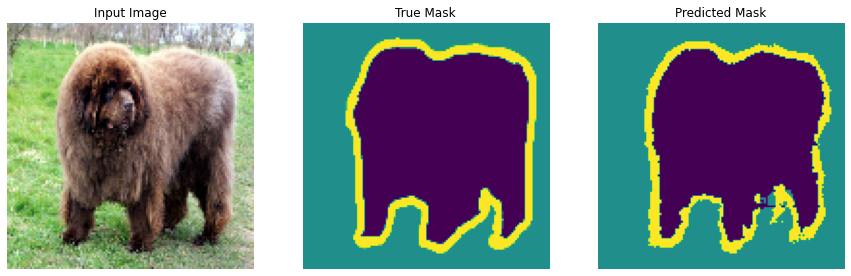


Sample Prediction after epoch 30

57/57 [==============================] - 170s 3s/step - loss: 0.1392 - accuracy: 0.9361 - val_loss: 0.4146 - val_accuracy: 0.8812


In [314]:
EPOCHS = 30
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

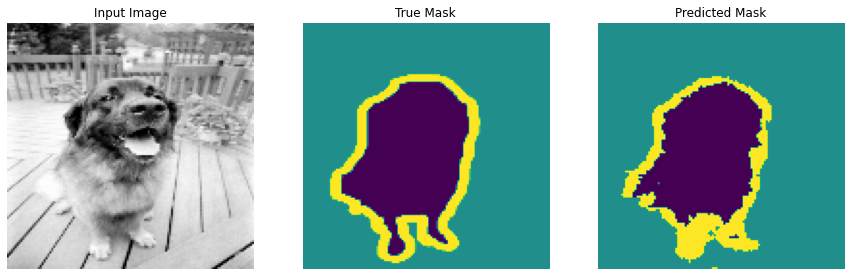

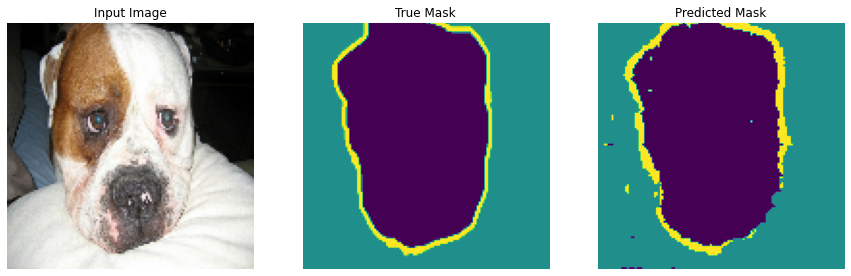

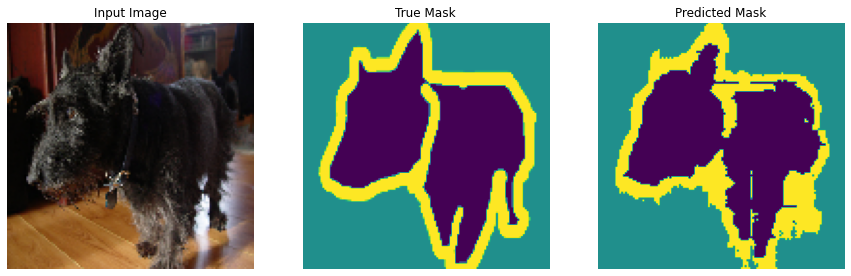

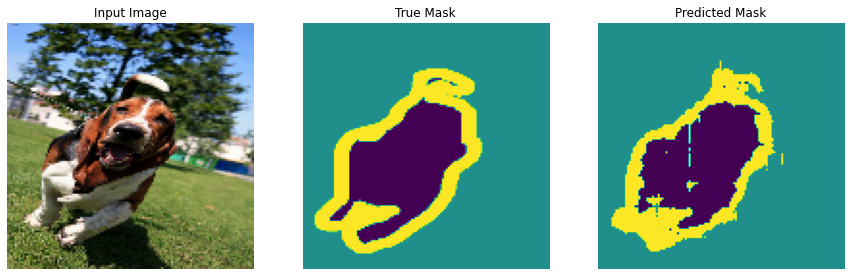

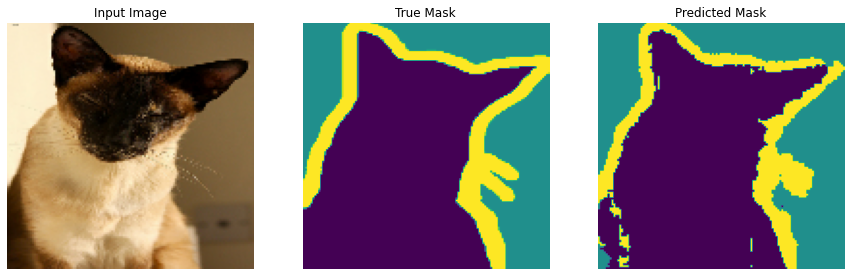

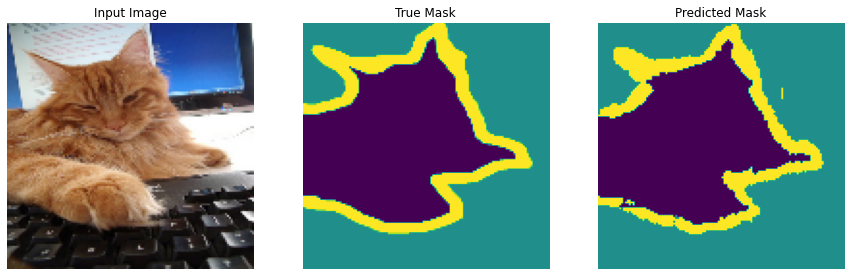

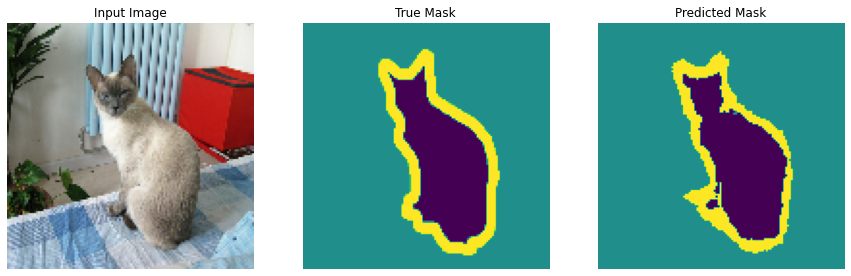

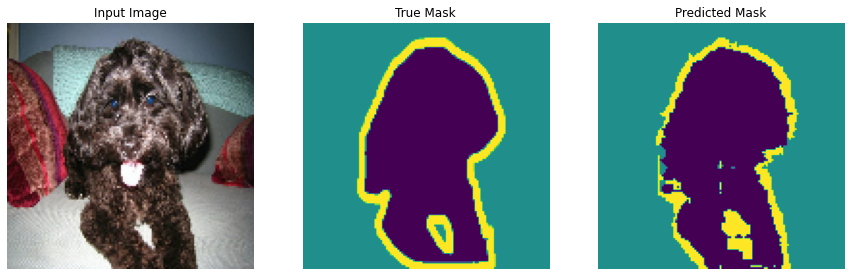

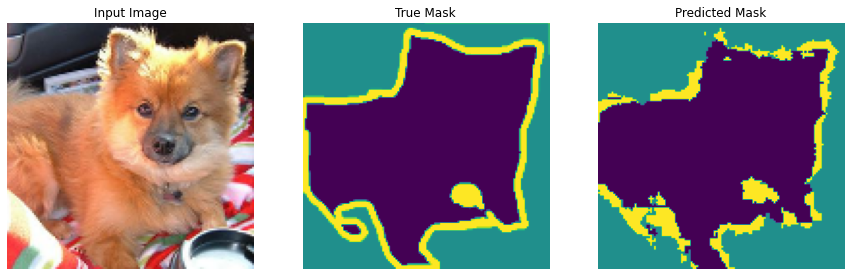

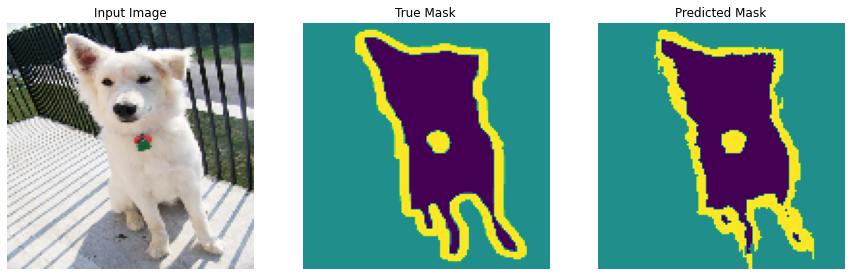

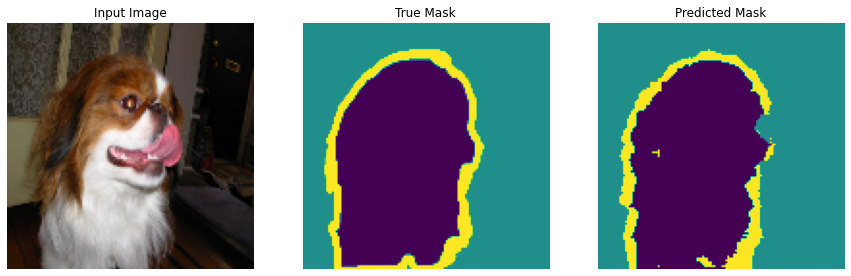

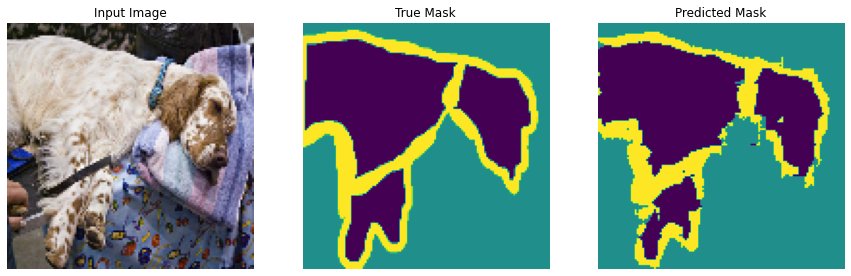

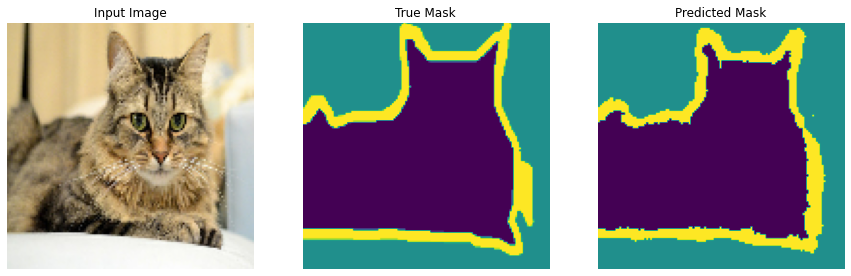

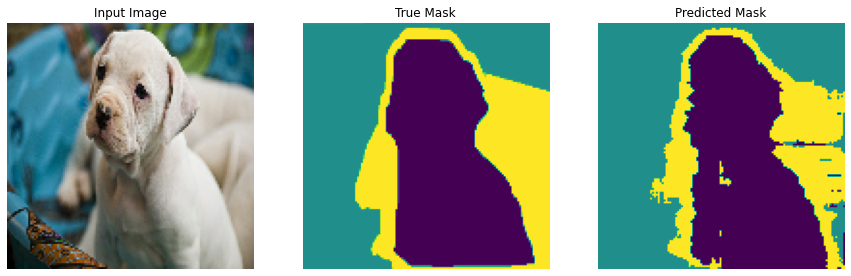

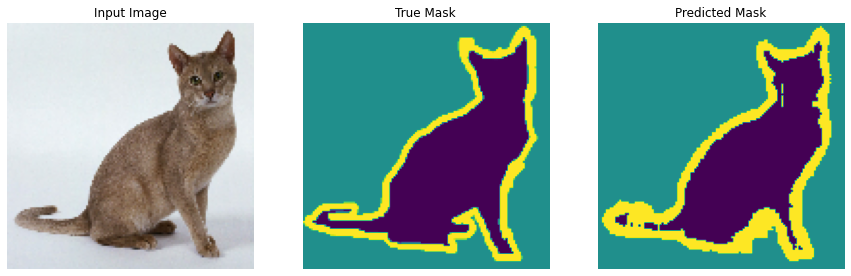

In [315]:
show_predictions(train_dataset, 15)

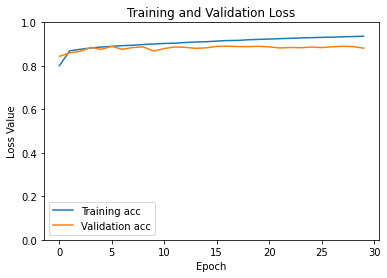

In [319]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

### Conclusion:

К сожалению я не смог выполнить полностью домашнее задание. Я все задания выполнял на google colab. Но это(задание) требует загрузки большого датасета ,что колаб ограничивает. В общем я использовал код из урока попытавшись изменить его и добится большей точности . Сильно это не помогло. В общем пока так.  